## Analysis of Gravity-driven Fluid Oscillations in a Drinking Straw

Analysis script for numerical solution of differential equation

In [34]:
# import libraries
import numpy as np
import scipy as sp
from ipywidgets import interact
from scipy.integrate import odeint
import matplotlib.pyplot as plt
# This makes the plots appear inside the notebook
%matplotlib inline
# %matplotlib nbagg

In [35]:
# parameters used throughout the code
h = 9 # immersion depth of straw, cm
H = 20 # length of straw, cm
g = 9.8 # gravity, ms^-2
D = 0.007 # diameter of straw, m

t_norm = (h*1e-2/g)**-0.5 #normalisation constant, 1e-2 cm to m

# Calculated using "http://www.met.reading.ac.uk/~sws04cdw/viscosity_calc.html"
# 0%, 10%, 20%, ..., 70% by volume
# all values at 23degC
rhos = [997.38, 1026.6, 1055.8, 1084.7, 1113.0,
        1140.3, 1166.6, 1191.6] # kg/m^3
etas = [0.00093505, 0.0012808, 0.0018249, 0.0027285, 0.0043309,
        0.0074104, 0.013960, 0.029822] # Ns/m^-2

In [50]:
filename = "50%V1"
data = np.genfromtxt(filename,delimiter='\t',skip_header=2)
time_data = data[:,0]
z_data = data[:,2]*100 # bc in m

timeshift = time_data[0] # shifted so that t=0 is the time in video that the cap is released.
time_data_clean = time_data[np.isfinite(z_data)]-timeshift # cleaned data includes the timeshift, and removes any instances of infinite.
z_data_clean = z_data[np.isfinite(z_data)]
z_err = np.full(shape=z_data_clean.shape, fill_value=0.)

z_0 = 1.954e-2 # height of liquid in straw, cm
conc = int(filename[0]) #2
eta = etas[conc] # Ns/m^-2
rho = rhos[conc] # kg/m^3
omeg = 16 * eta * (h * 10**-2)**0.5 / (rho * (D/2)**2 * g**0.5)
print(omeg)

0.8134196087647061


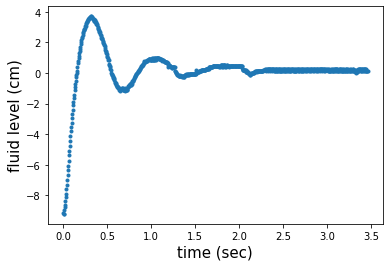

In [51]:
# plot raw data
plt.errorbar(time_data_clean[:],z_data_clean[:], yerr=z_err, fmt='.')
plt.xlabel('time (sec)',fontsize=15)
plt.ylabel('fluid level (cm)',fontsize=15)
plt.show()

In [52]:
# calculate the initial starting level of the fluid in the submersed straw using fluid statics:
P_atm = 1030 # g/cm^2
d = (1 - P_atm/(rho*(10**-3)*h + P_atm))*H
#z_0 = d
print('fluid level will be %2.2f cm above the bottom of the straw'%(d))

fluid level will be 0.20 cm above the bottom of the straw


We define the 0th column of the array Y as as $y$, 1th column of Z as $\dot{z}$. 

$$
\vec{Z} =  \begin{pmatrix}
z\\
\dot{z}
\end{pmatrix}
$$

Then our defined function DZ_dt returns the derivatives of the array Y: 

$$
\dot{\vec{Z}}=\begin{pmatrix}
\dot{z}\\ 
\ddot{z}
\end{pmatrix}
$$
as the right hand side of our ordinary differential equation, where $\ddot{z}$ is filled in for the derived expression in the differential equation.

The function odeint from scipy can solve this for $z(t)$. 

In [53]:
# Solving the Newton's law model and also equations 17a and 17b from Lorenceau paper:

# Lorenceau model:
def DZ_dt_Lor(Z, t, args):
    Omeg = args[0]
    if Z[1]>0:
        return [Z[1], 1/Z[0] - 1 -Omeg*Z[1] - (Z[1])**2/Z[0]]
    else:
        return [Z[1], 1/Z[0] - 1 -Omeg*Z[1]]
        
def model(t_data, h, factor):
    Omeg = omeg*factor
    params = (Omeg,)
    
    t_solnLor = np.arange(0, round(max(time_data_clean)*t_norm, 3), 0.001)
    Z_soln = sp.integrate.odeint(DZ_dt_Lor, [z_0, 0.00], t_solnLor, args=(params,))
    z_soln = Z_soln[:, 0]*h# - x_off # move computation down to the data
    t_solnLor /= t_norm # unnormalise to compare to real t_data
    zout = z_soln[np.searchsorted(t_solnLor, t_data)-1] # find corresponding t values and the z_soln for them
    return zout

def plot_osc(h=9, factor=2.60):
    # prepare data for plottin
    z_data1 = z_data_clean+h # change the overall level so that bottom of straw is z=0
    time_axis1 = time_data_clean  # only include data for positive times (after cap is released)
    
    # prepare parameters for solving models:
    Omeg = omeg*factor
    params=(Omeg,)
    
    # solve Lorenceau model, equation 17a and 17b....
    t_solnLor = np.arange(0, round(max(time_data_clean)*t_norm, 3), 0.01)
    Z_soln_Lor = sp.integrate.odeint(DZ_dt_Lor, [z_0, 0.00], t_solnLor, args=(params,))   
    
    z_soln_Lor = Z_soln_Lor[:,0]*h       # fluid height

    plt.clf()

    plt.xlabel('time (sec)',fontsize=15)
    plt.ylabel('fluid level (cm)',fontsize=15)
    plt.rc('xtick', labelsize=10)
    plt.rc('ytick', labelsize=10)

    plt.plot(t_solnLor/t_norm,z_soln_Lor,'g--',label='Lorenceau model')
    #plt.plot(time_axis1+t_off,z_data1+x_off,'b.',label='Data') 
    plt.errorbar(time_axis1, z_data1, yerr=z_err, fmt='b.',label='Data')

    plt.title('Fluid level oscillations with both models\nOmega=%2.2e (no unit), factor=%2.2e, h=%2.2e\nfilename = %s'%(Omeg, factor,h,filename),fontsize=15)
    plt.legend(frameon=False,loc=1)
    plt.xlim([-0.2,max(time_axis1)])
    plt.ylim(bottom=-.1)
    #plt.grid()
#     plt.savefig('fluid oscillation with fits.png',dpi=400)
    plt.show()

fittedparams = sp.optimize.curve_fit(model, xdata=time_data_clean, ydata=z_data_clean+h, p0=(9, 1), sigma=z_err)
print(["height","factor"], fittedparams[0], np.sqrt(np.diag(fittedparams[1])))
plot_osc(*(fittedparams[0]))
interact(plot_osc, x_off=(-15.00, 20.00, 0.01), h=(0.0, 20.0, 0.1), factor=(0, 10, 0.01))


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 600.

The above result is exciting! Both models match data *pretty well*!!!

# Going further: examining the frequency spectrum
Our analysis so far captures most of the relevant physics. However, sometimes looking in the frequency domain can give insights that weren't readily available in time-domain analysis...

NameError: name 'b' is not defined

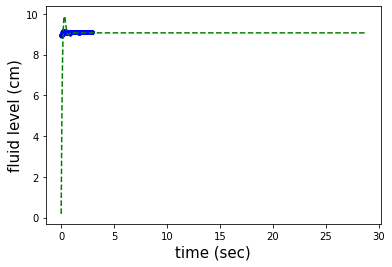

In [ ]:
h, factor = fittedparams[0]

z_data1 = z_data_clean+h # change the overall level so that bottom of straw is z=0
time_axis1 = time_data_clean  # only include data for positive times (after cap is released)

# prepare parameters for solving models:
Omeg = omeg*factor
params = (Omeg,)

# solve Newton model:
t_soln = time_axis1

# solve Lorenceau model, equation 17a and 17b....
t_solnLor = np.arange(0, 300, 0.01)
Z_soln_Lor = sp.integrate.odeint(DZ_dt_Lor, [z_0, 0.00], t_solnLor, args=(params,))   

z_soln_Lor = Z_soln_Lor[:,0]*h       # fluid height

plt.clf()
plt.plot(time_axis1,z_data1,'b.',label='Data') 

plt.xlabel('time (sec)',fontsize=15)
plt.ylabel('fluid level (cm)',fontsize=15)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

plt.plot(t_solnLor/t_norm,z_soln_Lor,'g--',label='Lorenceau model')
plt.title('Fluid level oscillations with both models\nOmega=%2.2e (no unit), h=%2.2f, b=%2.2e\nfilename = %s'%(Omeg,h,b,filename),fontsize=15)
plt.legend(frameon=False,loc=1)
plt.xlim([-0.2,max(time_axis1)])
plt.grid()
#     plt.savefig('fluid oscillation with fits.png',dpi=400)
plt.show()

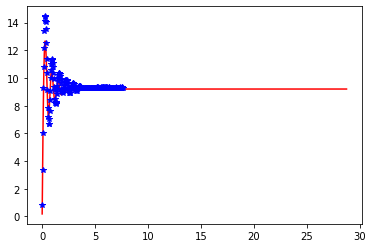

In [ ]:
# plot solution for longer time so as to get denser data points in the frequency spectrum:

t_soln_sec = t_solnLor/t_norm
plt.clf()
plt.plot(t_soln_sec,z_soln_Lor,'r',label='ode solution')
plt.plot(time_axis1,z_data1,'b*',label='y data') 
# plt.xlim([-.1,5])
plt.show()
z_soln = z_soln_Lor

In [ ]:
# perform the discrete Fourier transform of the model which is fit to the data:

Z_FFT = np.fft.fft(z_soln-np.mean(z_soln))
z2 = Z_FFT * np.conjugate(Z_FFT)
pow = abs(z2[1:len(Z_FFT)//2] + z2[:len(Z_FFT)//2:-1])
pow = pow/np.max(pow)
DT = t_soln_sec[1]-t_soln_sec[0]   # sample time
freq = (np.fft.fftfreq(t_soln_sec.shape[0])/DT)[1:len(Z_FFT)//2]

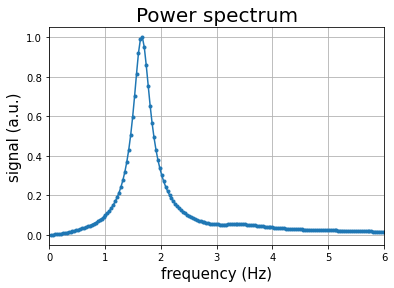

In [ ]:
# check the power spectrum:

title = 'Power spectrum'
xaxis_label = 'frequency (Hz)'
yaxis_label = 'signal (a.u.)'

plt.plot(freq,pow,'.-')

plt.xlabel(xaxis_label,fontsize=15)
plt.ylabel(yaxis_label,fontsize=15)
plt.grid()
plt.title(title,fontsize=20)
plt.xlim([0,6])
# plt.savefig('power spectrum.png',dpi=400)
plt.show()

In [ ]:
m = np.argmax(pow)
freq[m]

1.6695974231998432

Compare this peak value to the oscillation frequency that we can analytically derive in the limit of small oscillations:

$$ f = \frac{\omega}{2 \pi} = \frac{1}{2 \pi} \left ( \frac{g}{h} \right )^{1/2}$$

In [ ]:
h_guess = 9 # cm

In [ ]:
f_est = 1/(2*np.pi)*np.sqrt(g/(h_guess*10**-2)) # cm to m
print('small oscillation frequency = %2.3f Hz'%(f_est))

small oscillation frequency = 1.661 Hz


Fit the power spectrum with a Lorentzian function:

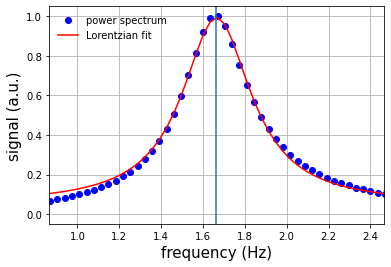

In [ ]:
def Lorentzian(x_val, h, w, x_c, y_0):
    return ((h * w**2)/((w**2)+(4*(x_val - x_c)**2)) + y_0)
h_g   = 1    #h = height
w_g   = 1        #w = fwhm
x_c_g = 1.5        #x_c = x val of peak
y_0_g = 0           #y_0 = y val of asymptote

fit_from_Hz = 0.5
fit_to_Hz = 2.5

fit_from_Hz = 1
fit_to_Hz = 2.5

fit_from = int(np.round(np.interp(fit_from_Hz,freq,np.arange(len(freq)))))
fit_to = int(np.round(np.interp(fit_to_Hz,freq,np.arange(len(freq)))))



#best fit lines (guesses help the process)
p_guess = [h_g, w_g, x_c_g, y_0_g]
peak, pcov = sp.optimize.curve_fit(Lorentzian, freq[fit_from:fit_to],pow[fit_from:fit_to], p0 = p_guess)

perr = np.sqrt(np.diag(pcov))
plt.plot(freq[:100],pow[:100],'bo',label = 'power spectrum')
# plt.plot(freq[:100], Lorentzian(freq[:100], *p_guess), 'g--',label='guess')
plt.plot(freq[:100], Lorentzian(freq[:100], *peak), 'r',label='Lorentzian fit')
plt.grid()

plt.axvline(x=f_est)
# plt.axvline(x=fit_to_Hz)
wdith_plot = 0.8
plt.xlim([peak[2]-wdith_plot,peak[2]+wdith_plot])
xaxis_label = 'frequency (Hz)'
yaxis_label = 'signal (a.u.)'
plt.xlabel(xaxis_label,fontsize=15)
plt.ylabel(yaxis_label,fontsize=15)
plt.legend(frameon=False,loc=2) 
plt.savefig('fig3 - frequency spectrum.png',dpi=400)
plt.show()

In [ ]:
print("Our fitted values using Lorentzian model:")
print("Height: %.9f"%(peak[0]),"a.u.")
print("FWHM : %.5f"%(peak[1]),"Hz")
print("Center: x =%.5f"%(peak[2]),"Hz")
print("Flatline: y =%.9f"%(peak[3]),"a.u.")
print()

Our fitted values using Lorentzian model:
Height: 0.945907518 a.u.
FWHM : 0.39961 Hz
Center: x =1.66483 Hz
Flatline: y =0.048051927 a.u.



In [ ]:
# the width of the power spectrum gives an estimate of the timescale of the decay:

FWHM = peak[1]
DT = 1/(FWHM)
print('The width of the power spectrum is %2.2f Hz which implies a decay time of DT=%2.2e sec'%(FWHM,DT))

The width of the power spectrum is 0.40 Hz which implies a decay time of DT=2.50e+00 sec


In [ ]:
print('discrepancy bw small oscillations and measured peak is %2.2f %%'%((f_est - peak[2])/f_est*100))

discrepancy bw small oscillations and measured peak is -0.24 %
